In [1]:
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import zipfile
import io

## Step 1: Download CR-UNSC Dataset from Zenodo

The dataset is hosted at: https://doi.org/10.5281/zenodo.7319780

I download the CSV variant which contains all resolutions with full text and metadata.

## Step 2: Load and Explore the Dataset

In [2]:
# Load CSV directly
df_unsc = pd.read_csv('/Users/luisafaust/Desktop/Seminar_Econ/data/CR-UNSC_2024-05-19_ALL_CSV_FULL.csv', low_memory=False)
print(f"Loaded {len(df_unsc):,} resolutions with {len(df_unsc.columns)} columns")

Loaded 2,722 resolutions with 82 columns


In [3]:
# Check text coverage for each language column
print("Text coverage by language:\n")
for col in ['text', 'text_ar', 'text_es', 'text_fr', 'text_ru', 'text_zh']:
    non_null = df_unsc[col].notna().sum()
    has_content = (df_unsc[col].notna() & (df_unsc[col].str.len() > 100)).sum()
    print(f"{col:15} : {non_null:,} non-null ({non_null/len(df_unsc)*100:.1f}%) | {has_content:,} with >100 chars ({has_content/len(df_unsc)*100:.1f}%)")

Text coverage by language:

text            : 2,722 non-null (100.0%) | 2,722 with >100 chars (100.0%)
text_ar         : 2,188 non-null (80.4%) | 2,187 with >100 chars (80.3%)
text_es         : 2,718 non-null (99.9%) | 2,716 with >100 chars (99.8%)
text_fr         : 2,490 non-null (91.5%) | 2,488 with >100 chars (91.4%)
text_ru         : 2,718 non-null (99.9%) | 2,716 with >100 chars (99.8%)
text_zh         : 2,639 non-null (97.0%) | 2,352 with >100 chars (86.4%)


In [4]:
# Overview of CSV structure
print("=" * 80)
print("CSV STRUCTURE OVERVIEW")
print("=" * 80)

print(f"\n DIMENSIONS:")
print(f"   Rows (resolutions): {len(df_unsc):,}")
print(f"   Columns (variables): {len(df_unsc.columns)}")

print(f"\nALL {len(df_unsc.columns)} COLUMNS:")
for i, col in enumerate(df_unsc.columns, 1):
    print(f"   {i:2}. {col}")

print(df_unsc[['date', 'res_no', 'symbol', 'nchars', 'ntokens']].head(3).to_string())

CSV STRUCTURE OVERVIEW

 DIMENSIONS:
   Rows (resolutions): 2,722
   Columns (variables): 82

ALL 82 COLUMNS:
    1. body
    2. call_number
    3. committee_report
    4. date
    5. doc_id
    6. doctype
    7. draft
    8. meeting_no
    9. meeting_record
   10. related_resource
   11. res_no
   12. symbol
   13. year
   14. nchars
   15. npages
   16. nsentences
   17. ntokens
   18. ntypes
   19. text
   20. text_ar
   21. text_draft
   22. text_es
   23. text_fr
   24. text_meeting
   25. text_ru
   26. text_zh
   27. agenda_information
   28. aggression
   29. chapter6
   30. chapter7
   31. chapter8
   32. contains
   33. human_rights
   34. notes
   35. other_titles
   36. peace_breach
   37. peace_threat
   38. self_defence
   39. series
   40. subjects
   41. summary
   42. title
   43. topic
   44. vote_abstention
   45. vote_date
   46. vote_detail
   47. vote_no
   48. vote_nonvote
   49. vote_summary
   50. vote_total
   51. vote_yes
   52. iso_alpha3
   53. iso_name
   

## Step 3: Filter Study Period (1990-2025)
WUI only available to 2024 Q1, which is why later filter 1990 - 2023

In [5]:
# Convert date to datetime
df_unsc['date'] = pd.to_datetime(df_unsc['date'])

# Filter to 1990-2025 Q3 to match WUI data
df_unsc_filtered = df_unsc[
    (df_unsc['date'] >= '1990-01-01') & 
    (df_unsc['date'] <= '2025-09-30')
].copy()

print(f"Resolutions in study period (1990-2025 Q3): {len(df_unsc_filtered)}")
print(f"Date range: {df_unsc_filtered['date'].min()} to {df_unsc_filtered['date'].max()}")

Resolutions in study period (1990-2025 Q3): 2076
Date range: 1990-01-11 00:00:00 to 2024-01-10 00:00:00


In [6]:
# Add quarterly period to match WUI
df_unsc_filtered['quarter'] = df_unsc_filtered['date'].dt.to_period('Q')

# Resolutions per year
# Checked that this matches WUI data (manual check done)
# print("\nResolutions per year:")
# print(df_unsc_filtered.groupby('year').size())
# Resolutions per quarter (for merging with WUI)
quarterly_counts = df_unsc_filtered.groupby('quarter').size()
print(f"\nQuarterly resolution counts (sample):")
print(quarterly_counts.head(20))
print(f"\nAverage resolutions per quarter: {quarterly_counts.mean():.2f}")
print("Manually checked if numbers match with resolution numbers on webside (https://main.un.org/securitycouncil/en/content/resolutions-0)")


Quarterly resolution counts (sample):
quarter
1990Q1     5
1990Q2     7
1990Q3    13
1990Q4    12
1991Q1     3
1991Q2    14
1991Q3    14
1991Q4    11
1992Q1    23
1992Q2    14
1992Q3    15
1992Q4    22
1993Q1    17
1993Q2    31
1993Q3    22
1993Q4    23
1994Q1    16
1994Q2    26
1994Q3    13
1994Q4    22
Freq: Q-DEC, dtype: int64

Average resolutions per quarter: 15.15
Manually checked if numbers match with resolution numbers on webside (https://main.un.org/securitycouncil/en/content/resolutions-0)


## Step 4: Check Text Quality and Availability

In [7]:
# Check how many resolutions have text
has_text = df_unsc_filtered['text'].notna() & (df_unsc_filtered['text'].str.len() > 100)
print(f"Resolutions with text (>100 chars): {has_text.sum()} / {len(df_unsc_filtered)}")
print(f"Coverage: {(has_text.sum() / len(df_unsc_filtered)) * 100:.1f}%")

# Text length statistics
df_unsc_filtered['text_length'] = df_unsc_filtered['text'].str.len()
print(f"\nText length statistics:")
print(df_unsc_filtered['text_length'].describe())

Resolutions with text (>100 chars): 2076 / 2076
Coverage: 100.0%

Text length statistics:
count      2076.000000
mean      11989.315511
std       15863.637458
min         288.000000
25%        3257.750000
50%        7009.000000
75%       14819.000000
max      343887.000000
Name: text_length, dtype: float64


## Step 5: Save Cleaned Dataset

In [8]:
# Save filtered dataset
output_file = 'data/unsc_resolutions_1990_2025.csv'
df_unsc_filtered.to_csv(output_file, index=False)
print(f"Saved filtered UNSC data to: {output_file}")

Saved filtered UNSC data to: data/unsc_resolutions_1990_2025.csv


## Step 6: Quick Visualization

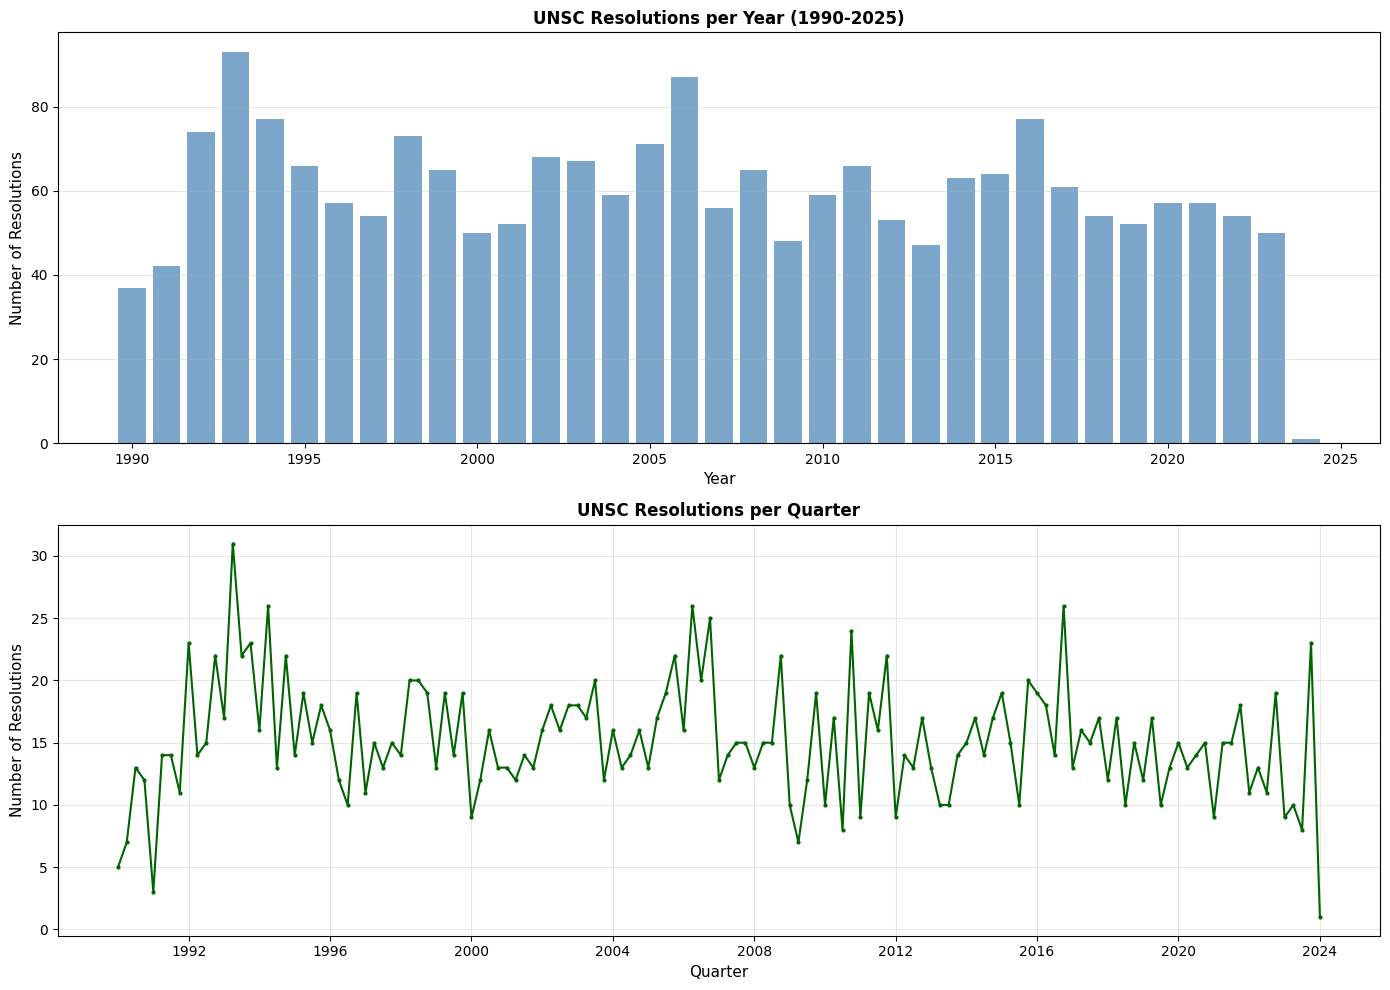


 UNSC Activity Summary:
Total resolutions: 2076
Average per year: 59.3


In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Resolutions per year
yearly_counts = df_unsc_filtered.groupby('year').size()
axes[0].bar(yearly_counts.index, yearly_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Number of Resolutions', fontsize=11)
axes[0].set_title('UNSC Resolutions per Year (1990-2025)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Resolutions per quarter (time series)
quarterly_counts_ts = df_unsc_filtered.groupby('quarter').size()
axes[1].plot(quarterly_counts_ts.index.to_timestamp(), quarterly_counts_ts.values, 
             linewidth=1.5, color='darkgreen', marker='o', markersize=2)
axes[1].set_xlabel('Quarter', fontsize=11)
axes[1].set_ylabel('Number of Resolutions', fontsize=11)
axes[1].set_title('UNSC Resolutions per Quarter', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n UNSC Activity Summary:")
print(f"Total resolutions: {len(df_unsc_filtered)}")
print(f"Average per year: {yearly_counts.mean():.1f}")